In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [4]:
spark = (
    SparkSession.builder.appName("proj-2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

24/09/17 10:07:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [10]:
consumer_fraud = pd.read_csv("../data/tables/synthetic/consumer_fraud_probability.csv")
consumer_ud = spark.read.parquet("../data/tables/synthetic/consumer_user_details.parquet")
merchant_fraud = pd.read_csv("../data/tables/synthetic/merchant_fraud_probability.csv")
consumer = pd.read_csv("../data/tables/synthetic/tbl_consumer.csv")
merchants = spark.read.parquet("../data/tables/synthetic/tbl_merchants.parquet")
transactions = spark.read.parquet("../data/tables/synthetic/transactions/*")

# Consumer fraud

In [11]:
consumer_fraud

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425
...,...,...,...
34859,18466,2022-02-22,8.679873
34860,17552,2021-12-26,8.349463
34861,17875,2021-06-27,8.288847
34862,10401,2021-09-18,8.842216


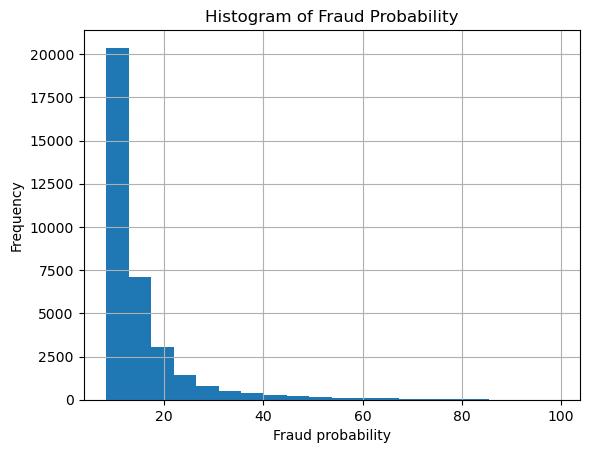

In [12]:
consumer_fraud['fraud_probability'].hist(bins=20)
plt.xlabel('Fraud probability')
plt.ylabel('Frequency')
plt.title('Histogram of Fraud Probability')
plt.show()

In [13]:
# Count the number of frauds for each user
consumer_fraud['fraud_count'] = consumer_fraud.groupby('user_id')['user_id'].transform('size')

# Arrange rows in order of ascending user_id
consumer_fraud = consumer_fraud.sort_values(by='user_id')

In [14]:
consumer_fraud

,user_id,order_datetime,fraud_probability,fraud_count
27248,1,2022-02-20,9.805431,1
30953,2,2021-09-25,10.069851,2
32296,2,2021-08-30,9.599514,2
29491,3,2021-11-03,8.300636,1
29620,4,2021-10-09,9.633302,1
...,...,...,...,...
22228,24079,2021-11-08,8.940524,4
19184,24079,2021-09-12,9.721157,4
8123,24079,2021-10-12,14.948165,4
14747,24081,2021-11-28,11.695397,2


In [15]:
# Calculate the average fraud probability for each user
fraud_summary = consumer_fraud.groupby('user_id').agg(
    fraud_probability_avg = ('fraud_probability', 'mean'),
    fraud_count = ('user_id', 'size')
    ).reset_index()

In [16]:
fraud_summary

,user_id,fraud_probability_avg,fraud_count
0,1,9.805431,1
1,2,9.834682,2
2,3,8.300636,1
3,4,9.633302,1
4,5,15.794925,3
...,...,...,...
20123,24075,18.463737,2
20124,24076,15.657614,1
20125,24078,15.048298,2
20126,24079,10.612117,4


# Consumer details

In [18]:
consumer_ud.limit(5)

user_id,consumer_id
1,1195503
2,179208
3,1194530
4,154128
5,712975


In [19]:
consumer_ud.count()

499999

In [20]:
consumer

,name|address|state|postcode|gender|consumer_id
0,Yolanda Williams|413 Haney Gardens Apt. 742|WA...
1,Mary Smith|3764 Amber Oval|NSW|2782|Female|179208
2,Jill Jones MD|40693 Henry Greens|NT|862|Female...
3,Lindsay Jimenez|00653 Davenport Crossroad|NSW|...
4,Rebecca Blanchard|9271 Michael Manors Suite 65...
...,...
499994,Jessica Avila|508 Miranda Overpass Apt. 218|QL...
499995,Steven Thornton|7913 Schwartz Mission Suite 48...
499996,Christy Smith|5681 Zachary Mountain Apt. 060|N...
499997,Donna Sutton|54140 Jacob Point|VIC|3989|Female...


In [21]:
# Split the consumer data into multiple columns
consumer[['name', 'address', 'state', 'postcode', 'gender', 'consumer_id']] = consumer['name|address|state|postcode|gender|consumer_id'].str.split('|', expand=True)
consumer = consumer.drop(columns=['name|address|state|postcode|gender|consumer_id'])

# Convert consumer_ud from spark to pandas
consumer_ud_pd = consumer_ud.toPandas()

# Convert consumer_id to the same type
consumer['consumer_id'] = consumer['consumer_id'].astype(str)
consumer_ud_pd['consumer_id'] = consumer_ud_pd['consumer_id'].astype(str)

# Combine all consumer data into one dataframe
consumer_df = pd.merge(consumer, consumer_ud_pd, on='consumer_id', how='left')

In [22]:
consumer_df

,name,address,state,postcode,gender,consumer_id,user_id
0,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,1
1,Mary Smith,3764 Amber Oval,NSW,2782,Female,179208,2
2,Jill Jones MD,40693 Henry Greens,NT,862,Female,1194530,3
3,Lindsay Jimenez,00653 Davenport Crossroad,NSW,2780,Female,154128,4
4,Rebecca Blanchard,9271 Michael Manors Suite 651,WA,6355,Female,712975,5
...,...,...,...,...,...,...,...
499994,Jessica Avila,508 Miranda Overpass Apt. 218,QLD,4400,Female,1385608,499995
499995,Steven Thornton,7913 Schwartz Mission Suite 483,VIC,3097,Undisclosed,1466964,499996
499996,Christy Smith,5681 Zachary Mountain Apt. 060,NSW,2756,Undisclosed,1253484,499997
499997,Donna Sutton,54140 Jacob Point,VIC,3989,Female,175005,499998


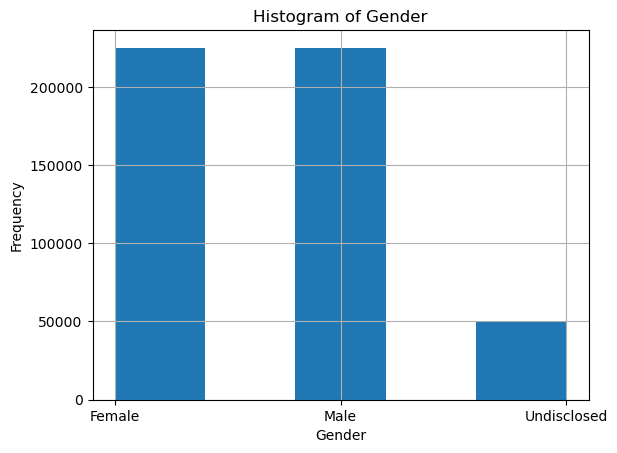

In [46]:
consumer_df['gender'].hist(bins=5)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Histogram of Gender')
plt.show()

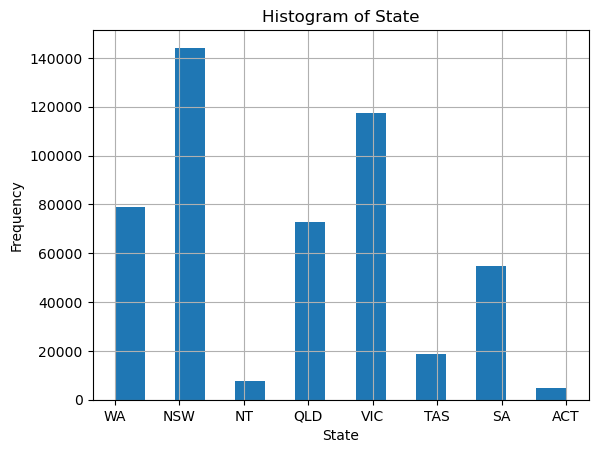

In [47]:
consumer_df['state'].hist(bins=15)
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Histogram of State')
plt.show()

In [23]:
# Add fraud data to consumer data
consumer_summary = pd.merge(consumer_df, fraud_summary, on='user_id', how='left')

# Replace missing values with 0
consumer_summary['fraud_probability_avg'].fillna(0, inplace=True)
consumer_summary['fraud_count'].fillna(0, inplace=True)

# Remove name column as it is irrelevant to our analysis
consumer_summary = consumer_summary.drop(columns=['name'])

In [24]:
consumer_summary

,address,state,postcode,gender,consumer_id,user_id,fraud_probability_avg,fraud_count
0,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,1,9.805431,1.0
1,3764 Amber Oval,NSW,2782,Female,179208,2,9.834682,2.0
2,40693 Henry Greens,NT,862,Female,1194530,3,8.300636,1.0
3,00653 Davenport Crossroad,NSW,2780,Female,154128,4,9.633302,1.0
4,9271 Michael Manors Suite 651,WA,6355,Female,712975,5,15.794925,3.0
...,...,...,...,...,...,...,...,...
499994,508 Miranda Overpass Apt. 218,QLD,4400,Female,1385608,499995,0.000000,0.0
499995,7913 Schwartz Mission Suite 483,VIC,3097,Undisclosed,1466964,499996,0.000000,0.0
499996,5681 Zachary Mountain Apt. 060,NSW,2756,Undisclosed,1253484,499997,0.000000,0.0
499997,54140 Jacob Point,VIC,3989,Female,175005,499998,0.000000,0.0


# Merchant fraud

In [25]:
# Convert merchants from spark to pandas
merchants = merchants.toPandas()

In [26]:
merchants

,name,tags,merchant_abn
0,Felis Limited,"((furniture, home furnishings and equipment sh...",10023283211
1,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...",10142254217
2,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...",10165489824
3,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...",10187291046
4,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...",10192359162
...,...,...,...
4021,Elit Dictum Eu Ltd,"[(opticians, optical goods, and eyeglasses), (...",99938978285
4022,Mollis LLP,"((books, periodicals, and newspapers), (b), (t...",99974311662
4023,Sociosqu Corp.,"((shoe shops), (a), (take rate: 6.57))",99976658299
4024,Commodo Hendrerit LLC,"[[motor vehicle Supplies and new parts], [a], ...",99987905597


In [27]:
merchant_fraud

,merchant_abn,order_datetime,fraud_probability
0,19492220327,2021-11-28,44.403659
1,31334588839,2021-10-02,42.755301
2,19492220327,2021-12-22,38.867790
3,82999039227,2021-12-19,94.134700
4,90918180829,2021-09-02,43.325517
...,...,...,...
109,80089686333,2021-09-01,67.505811
110,83220249221,2021-11-27,63.512459
111,85482742429,2021-11-27,70.881311
112,11470993597,2021-09-28,63.377344


In [28]:
# Count the number of frauds for each merchant
merchant_fraud['fraud_count'] = merchant_fraud.groupby('merchant_abn')['merchant_abn'].transform('size')

In [29]:
merchant_fraud

,merchant_abn,order_datetime,fraud_probability,fraud_count
0,19492220327,2021-11-28,44.403659,8
1,31334588839,2021-10-02,42.755301,12
2,19492220327,2021-12-22,38.867790,8
3,82999039227,2021-12-19,94.134700,1
4,90918180829,2021-09-02,43.325517,7
...,...,...,...,...
109,80089686333,2021-09-01,67.505811,1
110,83220249221,2021-11-27,63.512459,1
111,85482742429,2021-11-27,70.881311,1
112,11470993597,2021-09-28,63.377344,1


In [30]:
# Calculate the average fraud probability for each user
merchant_fraud_summary = merchant_fraud.groupby('merchant_abn').agg(
    fraud_probability_avg = ('fraud_probability', 'mean'),
    fraud_count = ('merchant_abn', 'size')
    ).reset_index()

# Sort rows in order of descending fraud_probability_avg
merchant_fraud_summary = merchant_fraud_summary.sort_values(by='fraud_probability_avg', ascending=False)

In [31]:
merchant_fraud_summary

,merchant_abn,fraud_probability_avg,fraud_count
42,82999039227,94.134700,1
20,35575706403,91.096068,1
59,97884414539,89.799200,1
3,14530561097,80.800545,1
13,23686790459,79.454344,1
...,...,...,...
55,94311056026,27.793256,2
31,75892370170,26.745292,1
30,73052515151,25.703547,1
28,67264251405,18.210891,1


# Transactions

In [32]:
transactions.limit(5)

user_id,merchant_abn,dollar_value,order_id
14935,79417999332,136.06570809815838,23acbb7b-cf98-458...
1,46451548968,72.61581642788431,76bab304-fa2d-400...
14936,89518629617,3.0783487174439297,a2ae446a-2959-41c...
1,49167531725,51.58228625503599,7080c274-17f7-4cc...
14936,31101120643,25.228114942417797,8e301c0f-06ab-45c...


In [34]:
transactions.count()

14195505

In [35]:
transactions = transactions.drop('order_id', 'order_datetime')

In [36]:
transactions.limit(5)

user_id,merchant_abn,dollar_value
14935,79417999332,136.06570809815838
1,46451548968,72.61581642788431
14936,89518629617,3.0783487174439297
1,49167531725,51.58228625503599
14936,31101120643,25.228114942417797


In [37]:
transactions_summary = transactions.groupBy('merchant_abn').agg(
    F.count('*').alias('transaction_count'),
    F.sum('dollar_value').alias('total_dollar_value'), 
    F.count_distinct('user_id').alias('total_users'))

In [38]:
transactions_summary.limit(10)

24/09/17 10:15:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:15:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:15:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:15:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:15:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:15:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:15:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:15:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:15:59 WARN RowBasedKeyValueBatch: Calling spill() on

merchant_abn,transaction_count,total_dollar_value,total_users
24406529929,4184,280125.2308976641,3826
12516851436,210,32325.484349738053,210
38700038932,7132,9546185.360697314,6170
73256306726,5263,1496967.1591142188,4717
83412691377,14288,498536.58169731364,10770
15613631617,1785,543030.531332826,1714
19839532017,726,113982.0,714
34440496342,215,19425.358828709977,215
35344855546,1522,134737.25046268434,1477
73841664453,959,83314.29045077677,938


In [39]:
transactions_summary = transactions_summary.toPandas()

24/09/17 10:16:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:16:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:16:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:16:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:16:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:16:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:16:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:16:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/17 10:16:48 WARN RowBasedKeyValueBatch: Calling spill() on

In [40]:
transactions_summary = transactions_summary.sort_values(by='total_dollar_value', ascending=False)

In [41]:
transactions_summary

,merchant_abn,transaction_count,total_dollar_value,total_users
1175,39649557865,21919,9.857402e+06,14462
822,96680767841,31134,9.806731e+06,17471
190,27093785141,25928,9.753404e+06,15836
1360,82368304209,5193,9.753248e+06,4649
1740,79827781481,4798,9.734168e+06,4314
...,...,...,...,...
2688,31570712230,73,1.018797e+04,73
3215,17028880379,48,1.013207e+04,48
973,25963848680,74,1.008303e+04,74
1149,59477140425,19,1.006493e+04,19


In [42]:
transactions_summary['avg_user_spending'] = transactions_summary['total_dollar_value']/transactions_summary['total_users']
transactions_summary['avg_transaction_value'] = transactions_summary['total_dollar_value']/transactions_summary['transaction_count']
transactions_summary['avg_user_transactions'] = transactions_summary['transaction_count']/transactions_summary['total_users']

In [43]:
transactions_summary

,merchant_abn,transaction_count,total_dollar_value,total_users,avg_user_spending,avg_transaction_value,avg_user_transactions
1175,39649557865,21919,9.857402e+06,14462,681.607131,449.719528,1.515627
822,96680767841,31134,9.806731e+06,17471,561.314816,314.984620,1.782039
190,27093785141,25928,9.753404e+06,15836,615.900722,376.172626,1.637282
1360,82368304209,5193,9.753248e+06,4649,2097.923801,1878.152850,1.117014
1740,79827781481,4798,9.734168e+06,4314,2256.413648,2028.797098,1.112193
...,...,...,...,...,...,...,...
2688,31570712230,73,1.018797e+04,73,139.561230,139.561230,1.000000
3215,17028880379,48,1.013207e+04,48,211.084718,211.084718,1.000000
973,25963848680,74,1.008303e+04,74,136.257146,136.257146,1.000000
1149,59477140425,19,1.006493e+04,19,529.733364,529.733364,1.000000


In [44]:
# Add merchant fraud data to consumer data
transactions_summary = pd.merge(transactions_summary, merchant_fraud_summary, on='merchant_abn', how='left')

# Replace missing values with 0
transactions_summary['fraud_probability_avg'].fillna(0, inplace=True)
transactions_summary['fraud_count'].fillna(0, inplace=True)

In [45]:
transactions_summary

,merchant_abn,transaction_count,total_dollar_value,total_users,avg_user_spending,avg_transaction_value,avg_user_transactions,fraud_probability_avg,fraud_count
0,39649557865,21919,9.857402e+06,14462,681.607131,449.719528,1.515627,28.690204,1.0
1,96680767841,31134,9.806731e+06,17471,561.314816,314.984620,1.782039,29.555245,1.0
2,27093785141,25928,9.753404e+06,15836,615.900722,376.172626,1.637282,28.880648,3.0
3,82368304209,5193,9.753248e+06,4649,2097.923801,1878.152850,1.117014,31.472067,2.0
4,79827781481,4798,9.734168e+06,4314,2256.413648,2028.797098,1.112193,29.735159,2.0
...,...,...,...,...,...,...,...,...,...
4417,31570712230,73,1.018797e+04,73,139.561230,139.561230,1.000000,0.000000,0.0
4418,17028880379,48,1.013207e+04,48,211.084718,211.084718,1.000000,0.000000,0.0
4419,25963848680,74,1.008303e+04,74,136.257146,136.257146,1.000000,0.000000,0.0
4420,59477140425,19,1.006493e+04,19,529.733364,529.733364,1.000000,0.000000,0.0
